# Inspect pyo

In [19]:
import pyo 

len(dir(pyo)) 

859

In [20]:
import tec
import pyo 

is_pyoobj_subclass = lambda o: isinstance(o, type) and issubclass(o, pyo.PyoObject) and o != pyo.PyoObject
pyobj_classes = dict(tec.name_and_object_pairs(pyo, obj_filt=is_pyoobj_subclass))
len(pyobj_classes)


239

In [21]:
# Note: All PyoObject subclasses are direct subclasses of PyoObject
assert all(v.mro()[1] == pyo.PyoObject for v in pyobj_classes.values()), (
    "Not all values are PyoObject or subclass of PyoObject"
)

In [ ]:
pyobj_classes_names = list(pyobj_classes.keys())
pyobj_classes_objs = list(pyobj_classes.values())



<function pyo.lib._core.PyoObject.play(self, dur=0, delay=0)>

In [ ]:
list(pyobj_classes)

['AToDB',
 'Abs',
 'Adsr',
 'Allpass',
 'Allpass2',
 'AllpassWG',
 'ArithmeticDummy',
 'Atan2',
 'Atone',
 'AttackDetector',
 'Average',
 'Balance',
 'BandSplit',
 'Beat',
 'Bendin',
 'Between',
 'Binaural',
 'Biquad',
 'Biquada',
 'Biquadx',
 'Blit',
 'BrownNoise',
 'ButBP',
 'ButBR',
 'ButHP',
 'ButLP',
 'CallAfter',
 'CarToPol',
 'Ceil',
 'Centroid',
 'CentsToTranspo',
 'Change',
 'ChenLee',
 'Choice',
 'Chorus',
 'Clip',
 'Cloud',
 'Compare',
 'ComplexRes',
 'Compress',
 'ControlRead',
 'ControlRec',
 'Convolve',
 'Cos',
 'Count',
 'Counter',
 'CrossFM',
 'CtlScan',
 'CtlScan2',
 'CvlVerb',
 'DBToA',
 'DCBlock',
 'Degrade',
 'Delay',
 'Delay1',
 'Denorm',
 'Disto',
 'Div',
 'Dummy',
 'EQ',
 'Euclide',
 'Exp',
 'Expand',
 'Expr',
 'Expseg',
 'FFT',
 'FM',
 'FToM',
 'Fader',
 'FastSine',
 'Floor',
 'Follower',
 'Follower2',
 'FourBand',
 'FrameAccum',
 'FrameDelta',
 'Freeverb',
 'FreqShift',
 'Gate',
 'Granulator',
 'Granule',
 'HRTF',
 'Harmonizer',
 'Hilbert',
 'IFFT',
 'IFFTMatri

# synth funcs: play or not play

In [81]:
from hum.pyo_util import PyoPlayAnalyzer, analyze_synth_func_play
from hum import synth_funcs, Synth
from time import sleep

In [35]:
analyze_synth_func_play(synth_funcs.sine)

{}

In [ ]:
from hum.pyo_util import analyze_synth_func_play
from pyo import HarmTable, Fader, Osc, Sine, SPan
from time import sleep

def intro_high_sines(base_freq=4000, mod_freq=0.4, mod_mul=0.05):
    wav = HarmTable([0.1, 0, 0.2, 0, 0.1, 0, 0, 0, 0.04, 0, 0, 0, 0.02])
    fade = Fader(fadein=3, fadeout=20, mul=mod_mul)
    fade.play()
    mod = Osc(table=wav, freq=mod_freq)
    car = Sine(freq=[base_freq, base_freq + 40, base_freq - 10], mul=mod)
    pan = SPan(car, pan=[0, 0.5, 1], mul=fade)
    pan.play()
    car.play()
    return pan


print(analyze_synth_func_play(intro_high_sines))

with Synth(intro_high_sines) as s:
    sleep(4)
    s(base_freq=1000, mod_freq=0.7, mod_mul=0.20)
    sleep(4)


{'fade': {'class': 'Fader', 'must_be_played': True, 'play_called': True}, 'mod': {'class': 'Osc', 'must_be_played': True, 'play_called': False}, 'car': {'class': 'Sine', 'must_be_played': True, 'play_called': True}}


In [ ]:
# BREAKS

from hum.pyo_util import analyze_synth_func_play, Synth
from time import sleep
from pyo import DataTable, LinTable, Pulsar, Waveguide, Tone, WGVerb


def intro_crunch_pulsar(IpulseHz=110):
    wavPas = DataTable(size=256)  # default dummy waveform
    envPulse = LinTable([(0, 1), (8191, 1)])
    pas = Pulsar(
        table=wavPas,
        env=envPulse,
        freq=IpulseHz,
        frac=[IpulseHz * 0.5, IpulseHz * 0.48],
        interp=4,
        mul=1.25,
    )
    pas.play()
    # return pas
    rezons = Waveguide(pas, freq=[32.7032, 65.4064, 98.1, 81.758], dur=30, mul=0.1)
    rezfilt = Tone(rezons, freq=1500)
    rev = WGVerb(pas, feedback=0.99, cutoff=10000, bal=0.25, mul=0.75)
    return rezfilt + rev

analyze_synth_func_play(intro_crunch_pulsar)

with Synth(intro_crunch_pulsar) as s:
    sleep(2)
    s(IpulseHz=55)
    sleep(2)
    s(IpulseHz=200)
    sleep(2)

AttributeError: 'DataTable' object has no attribute 'play'

In [49]:
from pyo import LFO, Adsr, Sine
from hum.pyo_util import Synth
from time import sleep

@Synth(dials='freq', settings='waveform attack')
def simple_waveform_synth(freq=440, attack=0.01, waveform='sine'):
    env = Adsr(attack=attack, decay=0.1, sustain=0.8, release=0.1, dur=0, mul=0.5).play()
    wave = {
        'sine': Sine,
        'triangle': lambda freq, mul: LFO(freq=freq, type=3, mul=mul),
        'square': lambda freq, mul: LFO(freq=freq, type=1, mul=mul),
    }.get(waveform, Sine)
    return wave(freq=freq, mul=env)

with simple_waveform_synth as s:
    sleep(1)  # Play default settings for a second
    s(freq=440 * 3 / 2)  # Change to 660 Hz
    sleep(1) 
    s(freq=440, waveform='triangle')  # Change to triangle wave at 440 Hz
    sleep(0.5)  # Shorter wait this time
    s(waveform='square', attack=0.5)  # Change to square wave with longer attack
    sleep(2)  # Wait a bit longer
    s(waveform='sine')  # Change back to sine wave (attack still 0.5)
    sleep(1)  # Wait for the final change to be heard

In [50]:
s.get_recording()


[(0,
  {'freq': {'value': 440, 'time': 0.025, 'mul': 1, 'add': 0},
   'attack': 0.01,
   'waveform': 'sine'}),
 (1.4767272472381592, {'freq': 660.0}),
 (2.4776792526245117, {'freq': 440, 'waveform': 'triangle'}),
 (2.478951930999756, {'waveform': 'triangle'}),
 (2.9840199947357178, {'waveform': 'square', 'attack': 0.5}),
 (2.984469175338745, {'waveform': 'square', 'attack': 0.5}),
 (4.989527225494385, {'waveform': 'sine'}),
 (4.989880084991455, {'waveform': 'sine'}),
 (5.994330167770386, {})]

# Play midi files

In [8]:
import fluidsynth
import time
from pyo import *

# --- Step 1: Initialize FluidSynth and load the SoundFont ---
sf2_path = "'/Users/thorwhalen/Dropbox/Media/soundfonts/Arachno SoundFont - Version 1.0.sf2'"
midi_path = "'/Users/thorwhalen/Dropbox/Media/soundfonts/arachno-soundfont-10-sf2/MIDI Files/Covers/Instrumental/Camille Saint-Sa‰ns - Danse Macabre (Jason M. Stone).mid'"

fs = fluidsynth.Synth()
fs.start(driver="alsa" if sys.platform.startswith("linux") else "coreaudio")  # or "dsound" on Windows

sfid = fs.sfload(sf2_path)
fs.program_select(0, sfid, 0, 0)

# --- Step 2: Play the MIDI file ---
fs.play_midi(midi_path)

# Give it some time to play or render.
time.sleep(30)  # Adjust based on MIDI length

fs.delete()

fluidsynth: error: fluid_sfloader_load(): Failed to open ''/Users/thorwhalen/Dropbox/Media/soundfonts/Arachno SoundFont - Version 1.0.sf2'': File does not exist.
fluidsynth: error: Unable to open file ''/Users/thorwhalen/Dropbox/Media/soundfonts/Arachno SoundFont - Version 1.0.sf2''
fluidsynth: error: Failed to load SoundFont "'/Users/thorwhalen/Dropbox/Media/soundfonts/Arachno SoundFont - Version 1.0.sf2'"
fluidsynth: error: There is no preset with bank number 0 and preset number 0 in SoundFont -1


AttributeError: 'Synth' object has no attribute 'play_midi'

In [3]:
>>> from pyo import *
>>> s = Server().boot()
>>> s.start()
>>> notes = Notein(poly=10, scale=1, mul=.5)
>>> p = Port(notes['velocity'], .001, .5)
>>> b = Sine(freq=notes['pitch'], mul=p).out()
>>> c = Sine(freq=notes['pitch'] * 0.997, mul=p).out()
>>> d = Sine(freq=notes['pitch'] * 1.005, mul=p).out()
# >>> from time import sleep
# >>> sleep(4)
# >>> s.stop()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).


In [5]:
s.stop()


In [ ]:
>>> from pyo import *
>>> s = Server().boot()
>>> s.start()
>>> a = SfPlayer(SNDS_PATH + "/transparent.aif", loop=True)
>>> lfo = Sine(freq=[.2,.25], mul=.5, add=.5)
>>> a.out()
>>> d = Disto(a, drive=lfo, slope=.8, mul=.15).out()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: Portmidi warning: could not open midi input 0 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi warning: could not open midi output 1 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi closed.


< Instance of SfPlayer class >

In [ ]:
from taped import LiveWf, disp_wf
from itertools import islice

def record(n_samples=10000, sample_rate=22050):
    with LiveWf(sr=sample_rate) as live_audio_stream:
        wf = list(islice(live_audio_stream, n_samples))
    return disp_wf(wf, sample_rate)

record()

In [5]:
from taped import record

wf = record()  # Will recordin indefinitely: interrupt when you're finish recording!

In [3]:
from taped import disp_wf

len(wf)

110592

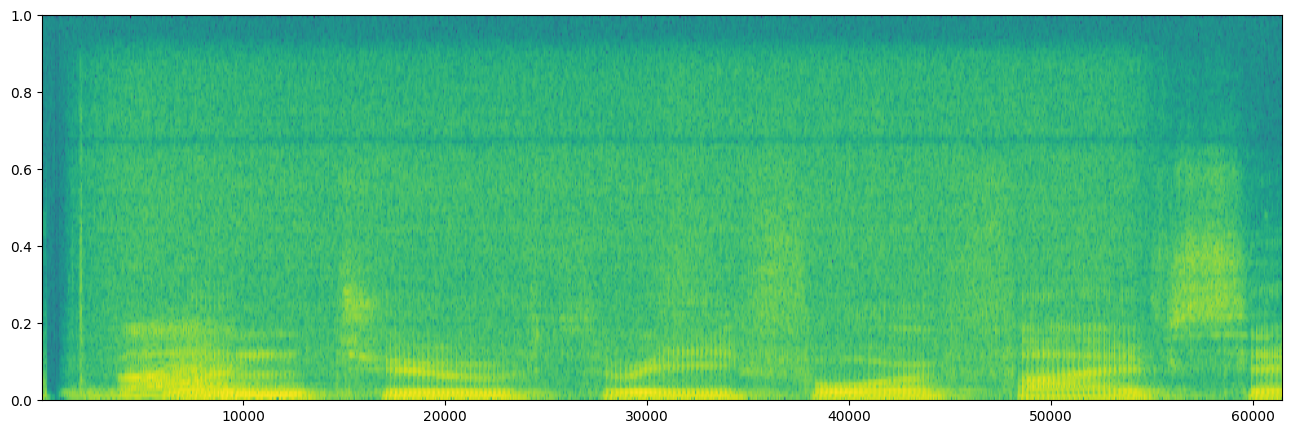

In [6]:
from taped import disp_wf 
disp_wf(wf)

In [10]:
import numpy as np
from pyo import *
import time

# Create your waveform as a NumPy array
sr = 44100  # Sampling rate
duration = 1.0  # seconds
t = np.linspace(0, duration, int(sr * duration), endpoint=False)
waveform = list(0.5 * np.sin(2 * np.pi * 440 * t))  # A 440Hz sine wave
# waveform = wf 

# Start server
s = Server().boot()
s.start()

# Create a NewTable and fill it with the waveform
tbl = NewTable(length=duration)
tbl.view()  # Optional: see it in TableView

# Copy NumPy data to the table
tbl.replace(waveform)

# Read the table
reader = TableRead(tbl, freq=tbl.getRate(), loop=False, mul=0.5).out()

time.sleep(1.5)  # Let it play

s.stop()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).


In [ ]:
import numpy as np
from pyo import *
import time

# Server
s = Server().boot()
s.start()

# Example waveform (replace with your own array)
sr = 44100
duration = 2.0
t = np.linspace(0, duration, int(sr * duration), endpoint=False)
waveform = wf

# Load waveform into NewTable
tbl = NewTable(length=duration)
tbl.replace(waveform)

# Table reader, looping like SfPlayer
a = TableRead(tbl, freq=tbl.getRate(), loop=True, mul=0.02)

# LFO for distortion drive
lfo = Sine(freq=[0.2, 0.25], mul=0.1, add=0.5)

# Output original sound
a.out()

# Distortion effect
# d = Disto(a, drive=lfo, slope=0.8, mul=0.05).out()

# Let it run
time.sleep(5)

s.stop()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).


< Instance of TableRead class >

# Misc

In [8]:
from pyo import *
import time

# Start the server
s = Server().boot()
s.start()

# Sine partials for harmonic richness
fund = 220
partials = [1, 2.01, 3.98, 5.01, 7]
amps = [0.3, 0.2, 0.15, 0.1, 0.05]

# Envelope (ADSR)
env = Adsr(attack=0.01, decay=0.3, sustain=0.6, release=0.5, dur=2.0, mul=1)
osc = Sine(freq=[fund * p for p in partials], mul=[a * env for a in amps])
out = osc.mix(1).out()

# Trigger the note
env.play()

# Let the sound finish before stopping the server
time.sleep(3)

s.stop()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).


In [75]:
from theremin.audio import natural_sounding_synth
from hum.pyo_util import Synth
from time import sleep
from functools import partial


s = Synth(natural_sounding_synth, synth_func_kwargs={'instrument': 'violin'})

with s:
    sleep(2)

## snap to scale

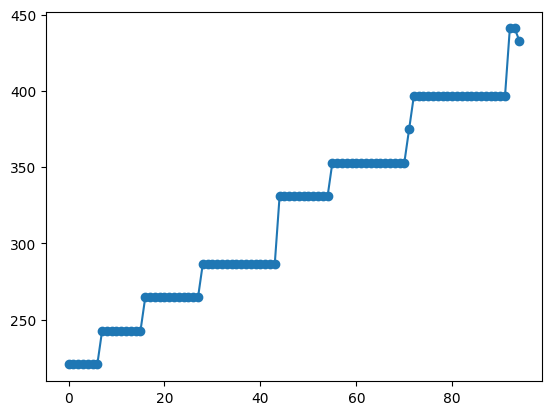

In [ ]:
from hum.util import scale_snapper
from hum import Synth
from hum.synth_funcs import sine
from time import sleep
import recode

snap_to_c_major = scale_snapper()

synth = Synth(sine, value_trans={'freq': snap_to_c_major})

# with synth as s:
#     for f in range(220, 440, 5):
#         s(freq=f)
#         sleep(0.1)

def gen_events():
    for i, f in enumerate(range(220, 440, 5)):
        yield 0.1 * i, {'freq': f}

events = list(gen_events())

wav_bytes = synth.render_events(events)
wf, sr = recode.decode_wav_bytes(wav_bytes)

from hum.extra_util import estimate_frequencies
from hum.util import round_numbers
from IPython.display import Audio

t = list(round_numbers(estimate_frequencies(wf, sr, chunker=2000), round_to=0.01))
len(t)

from matplotlib import pyplot as plt

plt.plot(t, '-o')
Audio(wav_bytes)


[220, 340]

In [3]:
from time import sleep
from hum import Synth
from pyo import Sine

def sine(freq=440, volume=0.3):
    return Sine(freq=freq, mul=volume)


snapper = lambda x: 250 if x < 500 else 500


with Synth(sine, value_trans={'freq': snapper}) as s:
    sleep(1)
    s(freq=600)
    sleep(1)
    s(freq=300)
    sleep(1)


In [ ]:

with Synth(sine) as s:
    sleep(1)
    s(freq=600)
    sleep(1)
    s(freq=300)
    sleep(1)


In [42]:
from theremin.video_features import video_feature_ranges

list(video_feature_ranges)
'l_wrist_position_x' in video_feature_ranges

True

In [80]:
semitones_in_c_major = np.array([0, 2, 4, 5, 7, 9, 11])
scale_freqs = []

for octave in range(0, 9):
    base_midi = 12 * octave
    for st in semitones_in_c_major:
        midi_note = base_midi + st
        hz = 440.0 * 2 ** ((midi_note - 69) / 12)
        scale_freqs.append(hz)

scale_freqs = np.array(scale_freqs)
len(scale_freqs)
scale_freqs[:20]

array([ 8.17579892,  9.177024  , 10.30086115, 10.91338223, 12.24985737,
       13.75      , 15.43385316, 16.35159783, 18.35404799, 20.60172231,
       21.82676446, 24.49971475, 27.5       , 30.86770633, 32.70319566,
       36.70809599, 41.20344461, 43.65352893, 48.9994295 , 55.        ])

In [ ]:
# min_freq, max_freq = audio_feature_ranges['l_freq']
        # min_freq, max_freq = audio_feature_ranges['r_freq']

        # if 'l_wrist_position' in video_features:
        #     knobs['l_freq'], knobs['l_volume'] = _calculate_freq_and_vol_from_wrist(
        #         video_features['l_wrist_position'], min_freq, max_freq
        #     )
        # if 'r_wrist_position' in video_features:
        #     knobs['r_freq'], knobs['r_volume'] = _calculate_freq_and_vol_from_wrist(
        #         video_features['r_wrist_position'], min_freq, max_freq
        # )

In [47]:
from theremin.util import json_lines

filepath = '/Users/thorwhalen/Dropbox/py/proj/t/theremin/misc/last_theremin_log.jsonl'

t = list(json_lines(filepath))
len(t)

1234

In [71]:
tt = t[50:]
video_features = list(filter(lambda x: 'r_wrist_position' in x or 'l_wrist_position' in x, tt))
audio_features = list(filter(lambda x: 'r_freq' in x or 'l_freq' in x, tt))
len(video_features), len(audio_features)

(592, 592)

In [77]:
import pandas as pd


video_features = pd.DataFrame(video_features)
audio_features = pd.DataFrame(audio_features)
features = pd.concat([video_features, audio_features], axis=1)
print(f"{video_features.shape=}, {audio_features.shape=}, {features.shape=}")
features.iloc[100]


video_features.shape=(592, 12), audio_features.shape=(592, 6), features.shape=(592, 18)


r_wrist_position                   [0.5422566533088684, 0.540729820728302, 9.0072...
r_palm_center                      [0.5080969383319219, 0.37615924576918286, -0.0...
r_finger_directions                {'0': [-0.07058897614479065, -0.10725465416908...
r_palm_normal                      [0.006312468448114417, -0.003104666736460691, ...
r_handedness                                                                    None
r_gesture                                                                       None
r_gesture_score                                                                 None
r_openness                                                                  0.327804
r_index_finger_extension_angle1                                           141.469686
r_index_finger_extension_angle2                                           142.956609
r_thumb_index_distance                                                      0.047319
r_is_pinching                                                    

In [79]:
features.describe().T

count         mean  ...          75%          max
r_openness                       592.0     0.165269  ...     0.203113     0.840977
r_index_finger_extension_angle1  592.0   160.396999  ...   169.346807   176.742586
r_index_finger_extension_angle2  592.0   137.243587  ...   175.861369   177.992915
r_thumb_index_distance           592.0     0.166735  ...     0.206978     0.779192
l_freq                           592.0   987.766603  ...   987.766603   987.766603
l_volume                         592.0     0.000000  ...     0.000000     0.000000
r_freq                           592.0  1115.519200  ...  1174.659072  1318.510228
r_volume                         592.0     0.449107  ...     0.495011     0.565201
vibrato_rate                     592.0     1.594967  ...     1.731208     4.027517
vibrato_depth                    592.0     1.111566  ...     1.379853     5.194612

[10 rows x 8 columns]

# Versions of the Synth

## A simple abstract Synth

In [ ]:
# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)



class Synth3:
    def __init__(self, synth_func, param_specs):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo controls
        raw_params = {
            name: SigTo(value=spec['value'], time=spec.get('time', 0.05))
            for name, spec in param_specs.items()
        }
        self.sound_params = ParamSet(raw_params)

        # Generate audio graph using the provided function
        self.output = synth_func(raw_params).out()

    def start(self):
        self.output.out()
        self.server.start()
        return self

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

    __enter__ = start
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.stop()





In [ ]:
def synth_graph(params):
    osc = Sine(freq=params['freq'])
    lfo = Sine(freq=params['tempo'] / 60.0).range(0.2, 1.0)
    modulated = osc * params['amp'] * lfo
    return ButLP(modulated, freq=params['cutoff'])


param_specs = {
    'freq': {'value': 440, 'time': 0.05},
    'amp': {'value': 0.5},
    'cutoff': {'value': 1000},
    'tempo': {'value': 120},
}

obj = Synth3(synth_graph, param_specs)

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: Portmidi warning: could not open midi input 0 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi warning: could not open midi output 1 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi closed.
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 1200


In [ ]:
obj.sound_params['cutoff'] = 200  # Very muffled


In [ ]:
obj.sound_params['cutoff'] = SigControl(value=4000, time=1.0)  # Slowly brightens

In [ ]:
obj.stop()

## A concrete version of Synth

In [ ]:
from pyo import *

# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)

# Main synth class
class Synth2:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo parameters
        raw_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        self.sound_params = ParamSet(raw_params)

        # Synth processing chain
        osc = Sine(freq=raw_params['freq'])
        lfo = Sine(freq=raw_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = osc * raw_params['amp'] * lfo
        self.filtered = ButLP(modulated, freq=raw_params['cutoff'])

        self.output = self.filtered.out()

    def start(self):
        self.output.out()
        self.server.start()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

In [ ]:
obj = Synth2()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 660  # Smoothly changes freq

In [ ]:
obj.sound_params['freq'] = SigControl(value=200, time=0.8)  # Custom time

In [ ]:
obj.sound_params['amp'].time = 0.3  # Change ramp time


In [ ]:
obj.sound_params['tempo'] = 60

In [ ]:
obj.sound_params['tempo'].play()  # Direct access to SigTo methods

< Instance of SigTo class >

In [ ]:
obj.stop()

## A simple, concrete version of Synth

In [ ]:
from pyo import *

class Synth1:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        # Boot server in non-GUI, realtime mode
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Sound parameters as SigTo for smooth changes
        self.sound_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        # Oscillator and modulations
        self.osc = Sine(freq=self.sound_params['freq'])
        self.lfo = Sine(freq=self.sound_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = self.osc * self.sound_params['amp'] * self.lfo
        self.filtered = ButLP(modulated, freq=self.sound_params['cutoff'])

        # Output
        self.output = self.filtered.out()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def start(self):
        self.output.out()
        self.server.start()

    def __del__(self):
        self.server.stop()


In [ ]:
obj = Synth1()

In [ ]:
obj.sound_params['freq'].value = 300

In [ ]:
obj.stop()

In [ ]:
list(obj.sound_params)

['freq', 'amp', 'cutoff', 'tempo']

In [3]:
from hum.tests.test_pyo_synth import test_synth_frequency_sequence

s = test_synth_frequency_sequence()


In [5]:
s._server._audio

'dummy'

# More...

In [ ]:
keys_to_note_frequences = {
    'q': 65.41,
    'w': 69.30,
    'e': 73.42,
    'r': 77.78,
    't': 82.41,
    'y': 87.31,
    'u': 110,
    'i': 123.47,
    'o': 130.81,
    'p': 146.83,
    '[': 164.81,
    ']': 174.61,
    '\\\\': 185.00,
    'a': 220,
    's': 233.08,
    'd': 246.94,
    'f': 261.63,
    'g': 293.66,
    'h': 329.63,
    'j': 349.23,
    'k': 392.00,
    'l': 440.00,
    ';': 493.88,
    "\'": 523.25,
    'z': 554.37,
    'x': 587.33,
    'c': 622.25,
    'v': 659.25,
    'b': 698.46,
    'n': 739.99,
    'm': 783.99,
    ',': 830.61,
    '.': 880.00,
}



In [9]:
import json
json.dumps(keys_to_note_frequences)

'{"q": 65.41, "w": 69.3, "e": 73.42, "r": 77.78, "t": 82.41, "y": 87.31, "u": 110, "i": 123.47, "o": 130.81, "p": 146.83, "[": 164.81, "]": 174.61, "\\\\\\\\": 185.0, "a": 220, "s": 233.08, "d": 246.94, "f": 261.63, "g": 293.66, "h": 329.63, "j": 349.23, "k": 392.0, "l": 440.0, ";": 493.88, "\'": 523.25, "z": 554.37, "x": 587.33, "c": 622.25, "v": 659.25, "b": 698.46, "n": 739.99, "m": 783.99, ",": 830.61, ".": 880.0}'

```

python -m hum.examples.keyboard_control \
  --callback "hum.pyo_synths:sine" \
  --arg-mapping '{"q": 65.41, "w": 69.3, "e": 73.42, "r": 77.78, "t": 82.41, "y": 87.31, "u": 110, "i": 123.47, "o": 130.81, "p": 146.83, "[": 164.81, "]": 174.61, "a": 220, "s": 233.08, "d": 246.94, "f": 261.63, "g": 293.66, "h": 329.63, "j": 349.23, "k": 392.0, "l": 440.0, ";": 493.88, "z": 554.37, "x": 587.33, "c": 622.25, "v": 659.25, "b": 698.46, "n": 739.99, "m": 783.99, ",": 830.61, ".": 880.0}'

```

In [10]:

from hum import Synth
from hum.pyo_util import add_dials
from pyo import *


# @knob_exclude('waveform')
@add_dials('freq volume')
def theremin_synth(
    freq=440,
    volume=0.5,
    attack=0.01,
    release=0.1,
    vibrato_rate=5,
    vibrato_depth=5,
    *,
    waveform='sine',
):
    """
    Emulates a classic theremin sound.

    Parameters:
    - freq (float): Base frequency in Hz.
    - volume (float): Output volume (0 to 1).
    - waveform (str): Waveform type ('sine', 'triangle', 'square').
    - attack (float): Attack time in seconds.
    - release (float): Release time in seconds.
    - vibrato_rate (float): Vibrato frequency in Hz.
    - vibrato_depth (float): Vibrato depth in Hz.

    Returns:
    - PyoObject: The resulting audio signal.
    """
    # Select waveform
    waveforms = {
        'sine': Sine,
        'triangle': lambda freq, mul: LFO(freq=freq, type=3, mul=mul),
        'square': lambda freq, mul: LFO(freq=freq, type=1, mul=mul),
    }
    wave_class = waveforms.get(waveform, Sine)

    # Vibrato modulation
    vibrato = Sine(freq=vibrato_rate, mul=vibrato_depth)

    # Envelope
    env = Adsr(
        attack=attack, decay=0.1, sustain=0.8, release=release, dur=0, mul=volume
    )
    env.play()
    # Oscillator with vibrato
    osc = wave_class(freq=freq + vibrato, mul=env)

    return osc


In [11]:
s = Synth(theremin_synth)

In [18]:
with s:
    sleep(1)
    s(freq=1000)
    sleep(1)

PyoArgumentTypeError: Invalid initial value for knob 'waveform': sine. Expected a number or a dictionary with 'value', 'time', 'mul', and/or 'add' keys. Original error: bad argument at position 0 to "SigTo" (float or PyoObject expected, got <class 'str'>)

In [ ]:
from pyo import LFO, Noise, Biquadx, Adsr, Sine
from hum.pyo_util import Synth
from time import sleep

@Synth
def pulse_synth(freq=440, duty=0.5, volume=0.3):
    return LFO(freq=freq, sharp=duty, type=2, mul=volume)


@Synth(settings='type')
def noise_synth(cutoff=1000, q=1, volume=0.2, type=0):
    noise = Noise(mul=volume)
    return Biquadx(noise, freq=cutoff, q=q, type=type, stages=2)

@Synth(settings=['waveform', 'attack'])
def simple_waveform_synth(freq=440, attack=0.01, waveform='sine'):
    env = Adsr(attack=attack, decay=0.1, sustain=0.8, release=0.1, dur=0, mul=0.5).play()
    wave = {
        'sine': Sine,
        'triangle': lambda freq, mul: LFO(freq=freq, type=3, mul=mul),
        'square': lambda freq, mul: LFO(freq=freq, type=1, mul=mul),
    }.get(waveform, Sine)
    return wave(freq=freq, mul=env)

In [ ]:
with pulse_synth:
    sleep(1)
    pulse_synth(freq=440 * 3 / 2)
    sleep(1)
    pulse_synth(duty=0.01)
    sleep(1)
    pulse_synth(freq=440, duty=2)  # changing two knobs at the same time
    sleep(1)


In [ ]:
with noise_synth:
    sleep(1)
    noise_synth(cutoff=500)
    sleep(1)
    noise_synth(cutoff=2000)
    sleep(1)
    noise_synth(type=2)
    sleep(1)
    noise_synth(q=0.5)
    sleep(1)
    noise_synth(q=0.1)
    sleep(1)

In [ ]:
with simple_waveform_synth:
    sleep(1)
    simple_waveform_synth(freq=440 * 3 / 2)
    sleep(1)
    simple_waveform_synth(freq=440, attack=0.1)
    sleep(1)
    simple_waveform_synth(waveform='triangle')
    sleep(1)
    simple_waveform_synth(waveform='square')
    sleep(1)


In [ ]:
simple_waveform_synth.knobs

<Knobs ['freq', 'attack', 'waveform']>

In [ ]:
list(simple_waveform_)

## More
                           

In [ ]:
from hum.pyo_util import round_event_times
import recode

events = list(round_event_times(events, round_to=0.1))

wav_bytes = synth.render_events(events, suffix_buffer_seconds=0)
assert isinstance(wav_bytes, bytes)
assert len(wav_bytes) > 0, "No bytes returned"

wf, sr = recode.decode_wav_bytes(wav_bytes)
assert sr == DFLT_PYO_SR, "Sample rate mismatch"
total_duration = len(wf) / sr
assert total_duration == 3.0, f"Expected 3 seconds of audio, got {total_duration}"

from hum.util import estimate_frequencies

estimated_frequencies = list(map(int, estimate_frequencies(wf, sr, chunker=sr)))
assert estimated_frequencies == list(map(int, freq_sequence)), "Some frequences were different"



In [ ]:
from hum.util import simple_chunker

list(map(len, simple_chunker(wf, chk_size=sr)))

[44100, 44100, 44100]

In [ ]:
len(wf) / 44100

3.0

# Real time synth

In [ ]:
from hum.pyo_util import *
from pyo import *


In [ ]:
import recode 

def my_graph(frequency, tempo, amplitude, cutoff):
    osc = Sine(freq=frequency)
    lfo = Sine(freq=tempo / 60.0).range(0.2, 1.0)
    modulated = osc * amplitude * lfo
    return ButLP(modulated, freq=cutoff)

frames = [
    {'tempo': 120, 'frequency': 440, 'amplitude': 0.5, 'cutoff': 1000},
    {'tempo': 135, 'frequency': 330, 'amplitude': 0.7, 'cutoff': 500},
    {'tempo': 100, 'frequency': 550, 'amplitude': 0.3, 'cutoff': 2000},
    {'tempo': 150, 'frequency': 220, 'amplitude': 0.9, 'cutoff': 750},
    {'tempo': 110, 'frequency': 660, 'amplitude': 0.6, 'cutoff': 1500},
]

renderer = OfflineSynthRenderer(
    synth_func=my_graph,
    parameter_frames=frames,
    frame_durations=2.0,
    sr=44100,
    egress=recode.decode_wav_bytes,
)

wf, sr = renderer.render()
assert sr == 44100
assert isinstance(wf, list)
assert len(wf) == int(len(frames) * 2.0 * 44100)
assert isinstance(wf[0], int)


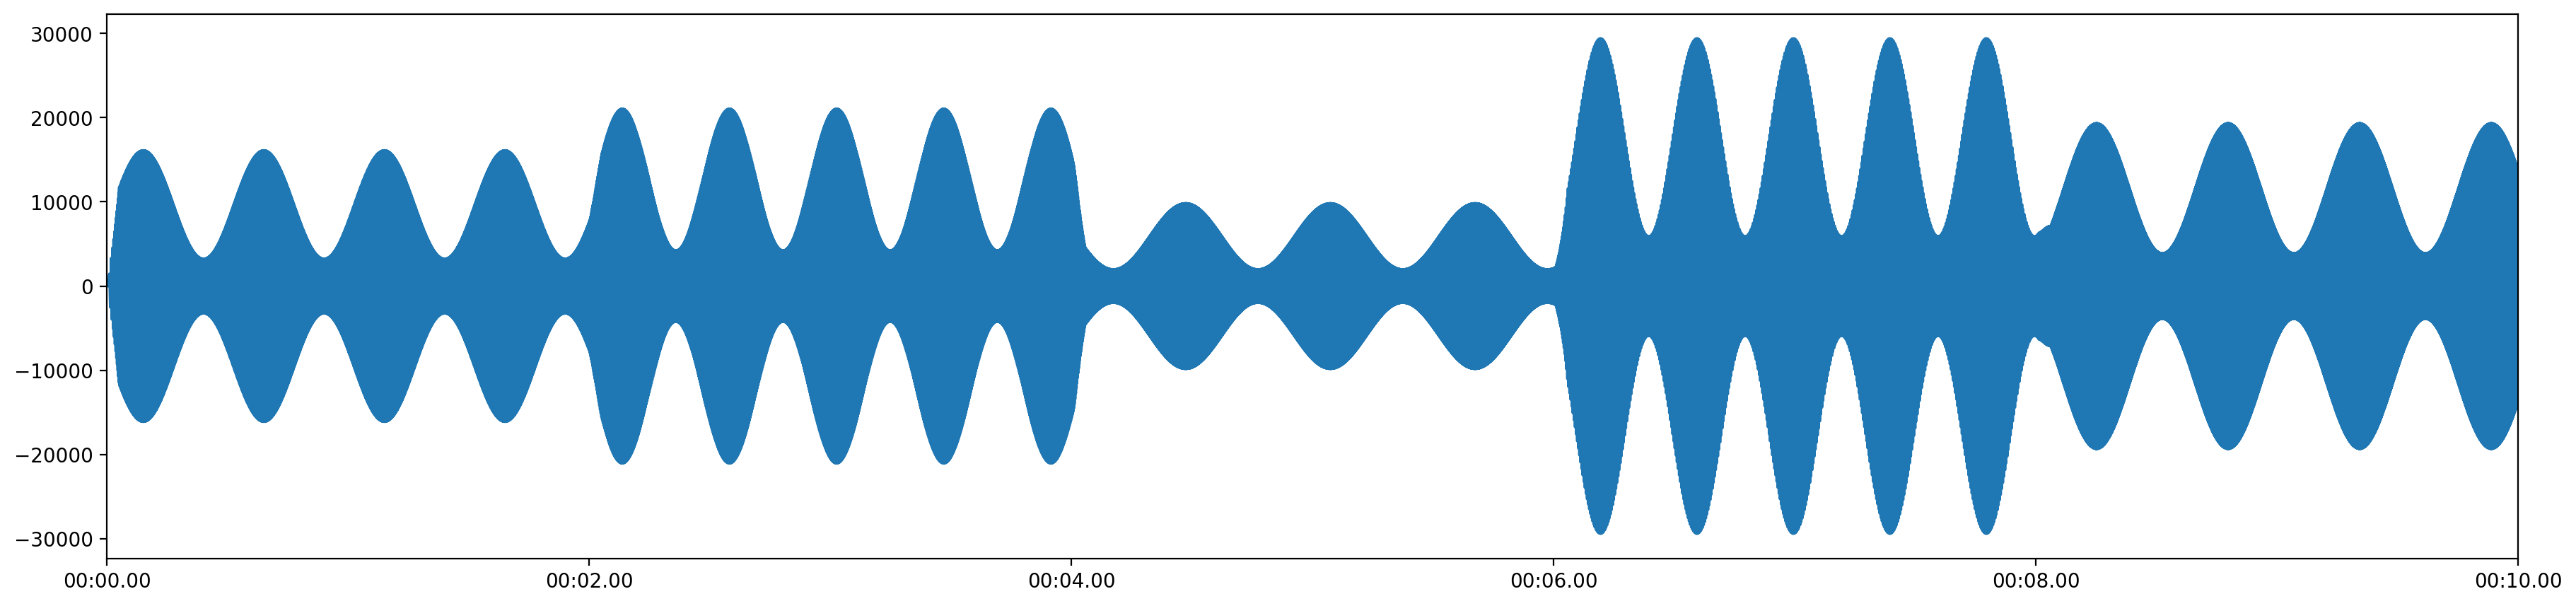

In [46]:
from hum import plot_wf
from IPython.display import Audio

plot_wf(wf, sr)
Audio(wf, rate=sr)

In [ ]:
def my_graph(params):
    osc = Sine(freq=params['frequency'])
    lfo = Sine(freq=params['tempo'] / 60.0).range(0.2, 1.0)
    modulated = osc * params['amplitude'] * lfo
    return ButLP(modulated, freq=params['cutoff'])

frames = [
    {'tempo': 120, 'frequency': 440, 'amplitude': 0.5, 'cutoff': 1000},
    {'tempo': 135, 'frequency': 330, 'amplitude': 0.7, 'cutoff': 500},
    {'tempo': 100, 'frequency': 550, 'amplitude': 0.3, 'cutoff': 2000},
    {'tempo': 150, 'frequency': 220, 'amplitude': 0.9, 'cutoff': 750},
    {'tempo': 110, 'frequency': 660, 'amplitude': 0.6, 'cutoff': 1500},
]

renderer = OfflineSynthRenderer(
    synth_func=my_graph,
    parameter_frames=frames,
    frame_durations=2.0,
    output_filepath="/Users/thorwhalen/tmp/offline_demo.wav"
)

b = renderer.render()
print(f"{len(b)=}, {type(b)=}")

Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
Pyo message: Offline Server rendering file /Users/thorwhalen/pyo_rec.wav dur=2.000000
Pyo message: Offline Server rendering finished.
len(b)=882044, type(b)=<class 'bytes'>


In [ ]:
from recode import decode_wav_bytes

wf, sr = decode_wav_bytes(b)

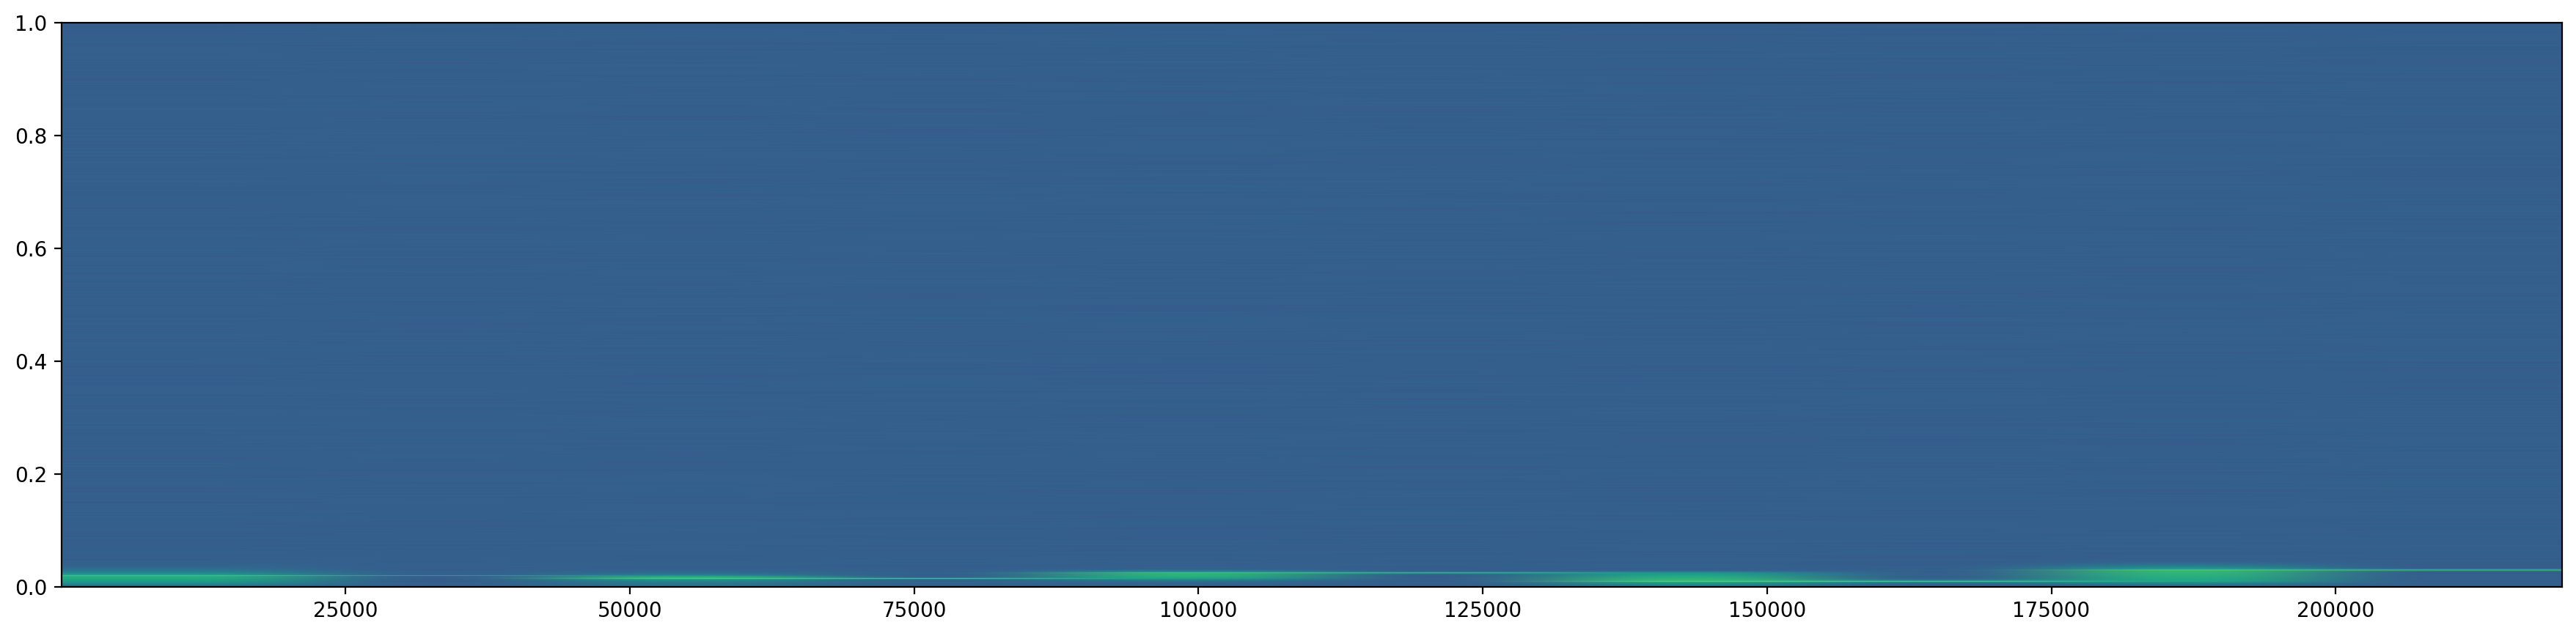

In [ ]:
from hum import disp_wf

disp_wf(wf, sr)

# Inspect pyo

In [ ]:
import pyo 

len(dir(pyo)) 

859

In [ ]:
import tec
import pyo 

is_pyoobj_subclass = lambda o: isinstance(o, type) and issubclass(o, pyo.PyoObject) and o != pyo.PyoObject
pyobj_classes = dict(tec.name_and_object_pairs(pyo, obj_filt=is_pyoobj_subclass))
len(pyobj_classes)


239

In [ ]:
# Note: All PyoObject subclasses are direct subclasses of PyoObject
assert all(v.mro()[1] == pyo.PyoObject for v in pyobj_classes.values()), (
    "Not all values are PyoObject or subclass of PyoObject"
)

In [ ]:
list(pyobj_classes)

['AToDB',
 'Abs',
 'Adsr',
 'Allpass',
 'Allpass2',
 'AllpassWG',
 'ArithmeticDummy',
 'Atan2',
 'Atone',
 'AttackDetector',
 'Average',
 'Balance',
 'BandSplit',
 'Beat',
 'Bendin',
 'Between',
 'Binaural',
 'Biquad',
 'Biquada',
 'Biquadx',
 'Blit',
 'BrownNoise',
 'ButBP',
 'ButBR',
 'ButHP',
 'ButLP',
 'CallAfter',
 'CarToPol',
 'Ceil',
 'Centroid',
 'CentsToTranspo',
 'Change',
 'ChenLee',
 'Choice',
 'Chorus',
 'Clip',
 'Cloud',
 'Compare',
 'ComplexRes',
 'Compress',
 'ControlRead',
 'ControlRec',
 'Convolve',
 'Cos',
 'Count',
 'Counter',
 'CrossFM',
 'CtlScan',
 'CtlScan2',
 'CvlVerb',
 'DBToA',
 'DCBlock',
 'Degrade',
 'Delay',
 'Delay1',
 'Denorm',
 'Disto',
 'Div',
 'Dummy',
 'EQ',
 'Euclide',
 'Exp',
 'Expand',
 'Expr',
 'Expseg',
 'FFT',
 'FM',
 'FToM',
 'Fader',
 'FastSine',
 'Floor',
 'Follower',
 'Follower2',
 'FourBand',
 'FrameAccum',
 'FrameDelta',
 'Freeverb',
 'FreqShift',
 'Gate',
 'Granulator',
 'Granule',
 'HRTF',
 'Harmonizer',
 'Hilbert',
 'IFFT',
 'IFFTMatri

pyo.lib._core.PyoObject

# Appendix: Cool code snippets

## Using generator.send to communicate to the synth

In [9]:
def echo():
    while True:
        value = yield  # Wait for a value to be sent
        print(f"Received: {value}")

# Create a generator
generator = echo()

# Start the generator
next(generator)

# Send values to the generator
generator.send("Hello")
generator.send("World")


class K:
    def __init__(self, generator_func, signature=None):
        self._generator_func = generator_func
        self._generator = generator_func()
        next(self._generator)  # prime the generator 
        if signature:
            self.__signature__ = signature

    def __call__(self, **kwargs):
        return self._generator.send(kwargs)

import i2
k = K(echo, signature=i2.Sig('(*, a=None, b=None, c=None)'))
k(a=1)
k(b=2, c=3)
i2.Sig(k)

Received: Hello
Received: World
Received: {'a': 1}
Received: {'b': 2, 'c': 3}


<Sig (*, a=None, b=None, c=None)>

# Synths

## Interface ideas

```py
synth = Synth(graph_func, *, ...)

# Two main functions:

synth.update_controls(control_kwargs)  # change some params, live


synth.play(control_kwargs_src: Iterator, delay_when_no_control_signal=1, ...)  # go through a sequence of synth.update_controls
# here, the process will loop (infinite loop, until an interrupt signal or control param is received)
# getting the control_kwargs = next(control_kwargs_src iterator) every time. 
#   If control_kwargs is not None (it should be a dict), then synth.update_controls(control_kwargs) is called
#   If control_kwargs is None, the process will sleep for delay_when_no_control_signal before relooping
# This should enable us to loop through a control_kwargs_src that is a finite sequence -- playing it, 
# and/or saving it to a file, and/or returning the waveform depending on what the user asks for 
# (as an argument of play(...)
# The same thing can also be used with some "live streaming controls" expressed 
# as an iterator that returns None when there are no new controls, or some controls control_kwargs
# (or list of control_kwargs that will be merged)...
```

```py
synth.update_controls(**control_kwargs)  # change some params, live, with synth.update_controls having a signature (so we can validate the control params)


synth.play(control_kwargs_src: Iterator, delay_when_no_control_signal=1)  # go through a sequence of synth.update_controls
# here, the process will loop (infinite loop, until an interrupt signal or control param is received)
# getting the control_kwargs = next(control_kwargs_src iterator) every time. 
# If control_kwargs is not None (it should be a dict), then synth.update_controls(**control_kwargs) is called
# If control_kwargs is None, the process will sleep for delay_when_no_control_signal before relooping

```

1745480349.522144

## Hybrid synth

In [14]:
from recode import decode_wav_bytes

# For precise control over segment durations in the offline rendering
synth = Synth(my_graph)

with synth:
    # First segment: 2 seconds
    synth.update_controls({'freq': 440, '_duration': 2.0})
    sleep(1)  # Actual playback time doesn't matter
    
    # Second segment: 3 seconds
    synth.update_controls({'freq': 880, '_duration': 3.0})
    sleep(0.5)  # Actual playback time doesn't matter

# Render with explicit durations
wf, sr = synth.render(egress=decode_wav_bytes)

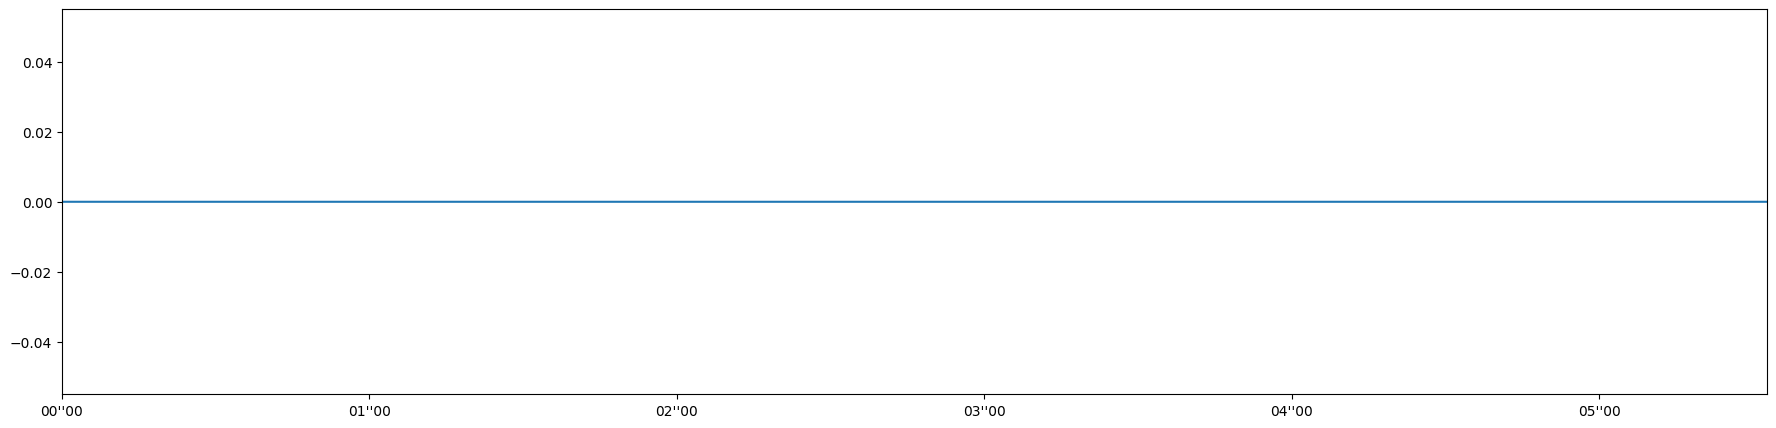

In [15]:
from hum import plot_wf
plot_wf(wf, sr)

## A simple abstract Synth

In [ ]:
# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)



class Synth3:
    def __init__(self, synth_func, param_specs):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo controls
        raw_params = {
            name: SigTo(value=spec['value'], time=spec.get('time', 0.05))
            for name, spec in param_specs.items()
        }
        self.sound_params = ParamSet(raw_params)

        # Generate audio graph using the provided function
        self.output = synth_func(raw_params).out()

    def start(self):
        self.output.out()
        self.server.start()
        return self

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

    __enter__ = start
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.stop()





In [ ]:
def synth_graph(params):
    osc = Sine(freq=params['freq'])
    lfo = Sine(freq=params['tempo'] / 60.0).range(0.2, 1.0)
    modulated = osc * params['amp'] * lfo
    return ButLP(modulated, freq=params['cutoff'])


param_specs = {
    'freq': {'value': 440, 'time': 0.05},
    'amp': {'value': 0.5},
    'cutoff': {'value': 1000},
    'tempo': {'value': 120},
}

obj = Synth3(synth_graph, param_specs)

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: Portmidi warning: could not open midi input 0 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi warning: could not open midi output 1 (IAC Driver Bus 1): PortMidi: Invalid device ID
Pyo warning: Portmidi closed.
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 1200


In [ ]:
obj.sound_params['cutoff'] = 200  # Very muffled


In [ ]:
obj.sound_params['cutoff'] = SigControl(value=4000, time=1.0)  # Slowly brightens

In [ ]:
obj.stop()

## A concrete version of Synth

In [ ]:
from pyo import *

# Wrapper to encapsulate value and time (optional)
class SigControl:
    def __init__(self, value=None, time=None):
        self.value = value
        self.time = time

# Wraps a SigTo object for intuitive control
class SigWrapper:
    def __init__(self, sigto_obj):
        self._sig = sigto_obj

    def __call__(self, val):
        self._sig.value = val

    def update(self, val):
        if isinstance(val, SigControl):
            if val.time is not None:
                self._sig.time = val.time
            if val.value is not None:
                self._sig.value = val.value
        else:
            self._sig.value = val

    def __getattr__(self, name):
        return getattr(self._sig, name)

    def __setattr__(self, name, val):
        if name in {"value", "time"}:
            setattr(self._sig, name, val)
        elif name == "_sig":
            super().__setattr__(name, val)
        else:
            raise AttributeError(f"Cannot set {name} on SigWrapper")

    def __repr__(self):
        return f"<SigWrapper value={self._sig.value}, time={self._sig.time}>"

# Container to simplify parameter control
class ParamSet:
    def __init__(self, param_dict):
        self._params = {k: SigWrapper(v) for k, v in param_dict.items()}

    def __getitem__(self, key):
        return self._params[key]

    def __setitem__(self, key, value):
        self._params[key].update(value)

# Main synth class
class Synth2:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Create SigTo parameters
        raw_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        self.sound_params = ParamSet(raw_params)

        # Synth processing chain
        osc = Sine(freq=raw_params['freq'])
        lfo = Sine(freq=raw_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = osc * raw_params['amp'] * lfo
        self.filtered = ButLP(modulated, freq=raw_params['cutoff'])

        self.output = self.filtered.out()

    def start(self):
        self.output.out()
        self.server.start()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def __del__(self):
        self.server.stop()

In [ ]:
obj = Synth2()

Pyo warning: Portaudio input device `MacBook Pro Microphone` has fewer channels (1) than requested (2).
Pyo warning: The Server must be started!


In [ ]:
obj.sound_params['freq'] = 660  # Smoothly changes freq

In [ ]:
obj.sound_params['freq'] = SigControl(value=200, time=0.8)  # Custom time

In [ ]:
obj.sound_params['amp'].time = 0.3  # Change ramp time


In [ ]:
obj.sound_params['tempo'] = 60

In [ ]:
obj.sound_params['tempo'].play()  # Direct access to SigTo methods

< Instance of SigTo class >

In [ ]:
obj.stop()

## A simple, concrete version of Synth

In [ ]:
from pyo import *

class Synth1:
    def __init__(self, freq=440, amp=0.5, cutoff=1000, tempo=120):
        # Boot server in non-GUI, realtime mode
        self.server = Server(audio='portaudio').boot()
        self.server.start()

        # Sound parameters as SigTo for smooth changes
        self.sound_params = {
            'freq': SigTo(value=freq, time=0.05),
            'amp': SigTo(value=amp, time=0.05),
            'cutoff': SigTo(value=cutoff, time=0.05),
            'tempo': SigTo(value=tempo, time=0.05),
        }

        # Oscillator and modulations
        self.osc = Sine(freq=self.sound_params['freq'])
        self.lfo = Sine(freq=self.sound_params['tempo'] / 60.0).range(0.2, 1.0)
        modulated = self.osc * self.sound_params['amp'] * self.lfo
        self.filtered = ButLP(modulated, freq=self.sound_params['cutoff'])

        # Output
        self.output = self.filtered.out()

    def stop(self):
        self.output.stop()
        self.server.stop()

    def start(self):
        self.output.out()
        self.server.start()

    def __del__(self):
        self.server.stop()


In [ ]:
obj = Synth1()

In [ ]:
obj.sound_params['freq'].value = 300

In [ ]:
obj.stop()

In [ ]:
list(obj.sound_params)

['freq', 'amp', 'cutoff', 'tempo']